In [5]:
import openpyxl
import requests
from fake_useragent import UserAgent
from bs4 import BeautifulSoup
import pandas as pd
from selenium import webdriver
from selenium import webdriver
import re
import requests
from lxml import html
from lxml import etree
import urllib
import re   
import unicodedata
import time
from Bio import Entrez
import networkx as nx
import pandas as pd

What do you want to search?

In [6]:
myquery = '"nanoparticles"AND"lung cancer"'

# 1. Get excel with abstracts

Add your personal key and email here to be able to access the PubMed database

Instructions to get your personal key can be found here: https://ncbiinsights.ncbi.nlm.nih.gov/2017/11/02/new-api-keys-for-the-e-utilities/


In [7]:
Entrez.email = 'ramin.y.shahrivar@gmail.com'


The api key is optional, but you can get more articles without error

In [8]:
Entrez.api_key = "aa1f7464c35c00206ac5717969613e858407"

Some helper functions...

In [9]:
def search(query,mymax):
    handle = Entrez.esearch(db='pubmed', 
                            sort='relevance', 
                            retmax=str(mymax),
                            retmode='xml', 
                            term=query)
    results = Entrez.read(handle)
    return results

def fetch_details(id_list):
    ids = ','.join(id_list)
    handle = Entrez.efetch(db='pubmed',
                           retmode='xml',
                           id=ids)
    results = Entrez.read(handle)
    return results

def fetch_details_2(id):
    handle = Entrez.efetch(db='pubmed',
                           retmode='xml',
                           id=id)
    results = Entrez.read(handle)
    return results

Get the results

In [10]:
titles=[]
aims=[]
mms=[]
ress=[]
concs=[] 
refs=[]
abs=[]
pmids = []
cited_by = []

mymax=100
results = search(myquery,mymax)
id_list = results['IdList'] # list of UIDs
chunk_size = 50 # whatever you like   
for chunk_i in range(0, len(id_list), chunk_size):
    chunk = id_list[chunk_i:chunk_i + chunk_size]
 
    papers = fetch_details(chunk)
    for i, paper in enumerate(papers['PubmedArticle']):
      try:
          data = paper.get('PubmedData')
          data2 = paper.get('MedlineCitation')
          article = data2.get('Article')
          title = article.get('ArticleTitle')
          abstr = article.get('Abstract')
          abstr = abstr.get('AbstractText')
          ref = data.get('ReferenceList')
          refs.append(ref)
          pmids.append(data2.get('PMID'))
          cited_by.append('')
          try:
            aim = abstr[0]
            MM = abstr[1]
            res = abstr[2]
            conc = abstr[3]
            titles.append(title)
            aims.append(aim)
            mms.append(MM)
            ress.append(res)
            concs.append(conc)
            abs.append('')
          except:
            abs.append(abstr[0])
            titles.append(title)
            aims.append('')
            mms.append('')
            ress.append('')
            concs.append('')
      except:
          pass


add them to a dataframe and download!

In [11]:
data = {'title': titles, 'id':pmids,'abs':abs,'aims':aims,'MM':mms,'res':ress,'concl':concs} 
df2 = pd.DataFrame(data) 

In [12]:
df2

,title,id,abs,aims,MM,res,concl
0,Novel therapeutic regimens for urethane-induce...,33332722,"Lung cancer remains incurable; therefore, nove...",,,,
1,Harnessing chlorin e6 loaded by functionalized...,34997349,Non-small-cell lung cancer (NSCLC) is the most...,,,,
2,5-Fluorouracil-Impregnated PLGA Coated Gold Na...,34951582,,The study aimed to investigate the augmented c...,"In this study, several formulations were prepa...",Characterization results showed spherical poly...,PLGA coated biogenic gold nanoparticles have a...
3,Silencing of survivin and cyclin B1 through si...,32956996,"With the development of nanotechnology, variou...",,,,
4,New insights into designing hybrid nanoparticl...,30639691,Lung cancer is the foremost reason of death fr...,,,,
...,...,...,...,...,...,...,...
95,Oseltamivir phosphate loaded pegylated-Eudragi...,34520775,The target of the current investigation was th...,,,,
96,Biodistribution and pharmacokinetics of Mad2 s...,26980454,,The present study focuses on biodistribution p...,Mad2 siRNA was encapsulated in EGFR targeted a...,TG nanoparticles showed a consistent and prefe...,TG nanoparticles present as an attractive drug...
97,"Non-small cell lung cancer-targeted, redox-sen...",31586902,"Afatinib (Afa), a second-generation irreversib...",,,,
98,Design of Lamivudine Loaded Nanoparticles for ...,32209039,,To prepare lamivudine (LAM)-loaded-nanoparticl...,The development of anticancer drugs is a diffi...,To characterize the LAM-loaded-NPs and examine...,LAM-loaded-NPs were prepared using Nano Spray-...


In [25]:
df2.to_excel('output.xlsx') 

# 2. Get the graph for the citations

Get the nodes and edges

In [13]:
nodes = []
edges = []
new_ids=[]
for i in range(len(refs)):
  temp = refs[i]
  name=str(pmids[i])
  if temp:
    if name not in nodes:
      nodes.append(name)
    temp2 = temp[0]
    A = temp2.get('Reference')
    for j in range(len(A)):
      temp3 = A[j].get('ArticleIdList')
      try:
        name2 = str(temp3[0])
        if name2 not in nodes:
          nodes.append(name2)
          new_ids.append(name2)

        edges.append((name,name2))
      except:
        pass

Build the graph

In [14]:
g = nx.Graph()
g.add_nodes_from(nodes)
for i in range(len(edges)):
  B = edges[i]
  g.add_edge(B[0], B[1])


color code the original papers in blue, the rest in red

In [23]:
color_map = []
for node in nodes:
    if node in pmids:
        color_map.append('blue')
    else: 
        color_map.append('red')      

get the graph

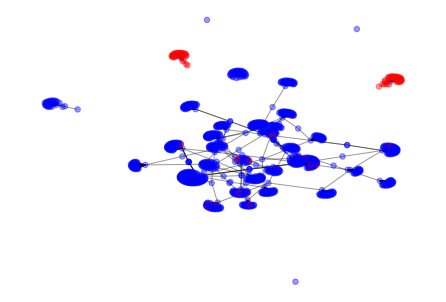

In [27]:
nx.draw(g,node_size=30, node_color=color_map,alpha=0.4)

Voilá!! 

now we can also get the abstracts for the references

In [18]:
mymax=100
id_list = new_ids # list of UIDs
chunk_size = 50 # whatever you like   
for chunk_i in range(0, len(id_list), chunk_size):
    chunk = id_list[chunk_i:chunk_i + chunk_size]
 
    papers = fetch_details(chunk)
    for i, paper in enumerate(papers['PubmedArticle']):
      try:
          data = paper.get('PubmedData')
          data2 = paper.get('MedlineCitation')
          article = data2.get('Article')
          title = article.get('ArticleTitle')
          abstr = article.get('Abstract')
          abstr = abstr.get('AbstractText')
          ref = data.get('ReferenceList')
          refs.append(ref)
          pmids.append(data2.get('PMID'))
          cited_by.append(str(g.degree(str(data2.get('PMID')))))
          try:
            aim = abstr[0]
            MM = abstr[1]
            res = abstr[2]
            conc = abstr[3]
            titles.append(title)
            aims.append(aim)
            mms.append(MM)
            ress.append(res)
            concs.append(conc)
            abs.append('')
          except:
            abs.append(abstr[0])
            titles.append(title)
            aims.append('')
            mms.append('')
            ress.append('')
            concs.append('')
      except:
          pass


add them to a dataframe

In [20]:
data = {'title': titles, 'id':pmids,'abs':abs,'aims':aims,'MM':mms,'res':ress,'concl':concs,'degree':cited_by} 
df2 = pd.DataFrame(data) 
df2

,title,id,abs,aims,MM,res,concl,degree
0,Novel therapeutic regimens for urethane-induce...,33332722,"Lung cancer remains incurable; therefore, nove...",,,,,
1,Harnessing chlorin e6 loaded by functionalized...,34997349,Non-small-cell lung cancer (NSCLC) is the most...,,,,,
2,5-Fluorouracil-Impregnated PLGA Coated Gold Na...,34951582,,The study aimed to investigate the augmented c...,"In this study, several formulations were prepa...",Characterization results showed spherical poly...,PLGA coated biogenic gold nanoparticles have a...,
3,Silencing of survivin and cyclin B1 through si...,32956996,"With the development of nanotechnology, variou...",,,,,
4,New insights into designing hybrid nanoparticl...,30639691,Lung cancer is the foremost reason of death fr...,,,,,
...,...,...,...,...,...,...,...,...
1491,Overexpression of MAD2 predicts clinical outco...,21376419,High-level expression of mitotic arrest defect...,,,,,1
1492,Neuropathy associated with microtubule inhibit...,18567992,Microtubule inhibitor (MTI)-based chemotherapi...,,,,,1
1493,Cyclodextrin-based siRNA delivery nanocarriers...,21867463,The discovery of synthetic small interfering R...,,,,,1
1494,Identification and characterization of a novel...,16319141,"Epidermal growth factor receptor (ErbB1, EGFR)...",,,,,1


and we can save/download the document 

In [ ]:
df2.to_excel('output.xlsx') 

Some of the posts I've used as references:

https://medium.com/@kliang933/scraping-big-data-from-public-research-repositories-e-g-pubmed-arxiv-2-488666f6f29b

https://github.com/CrossRef/rest-api-doc#queries
